In [2]:
import numpy as np
import pandas as pd

# Analysing FICO Score: Bucketing FICO Scores of Loan Borrowers

Objective: Develop a quantization approach to generate buckets for mapping FICO scores to ratings, where a lower rating corresponds to a better credit score.

Task: Design a method for finding the boundaries that best summarize the data using an appropriate optimization criterion, such as mean squared error or log-likelihood.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class Quantizer:
    def __init__(self, data_file, r):
        # Initialize with the data file path and number of partitions (buckets)
        self.dataframe = pd.read_csv(data_file)
        self.r = r
        self.n = len(self.dataframe)
        self.x = self.dataframe['default'].to_list()  # 1 if defaulted, 0 otherwise
        self.y = self.dataframe['fico_score'].to_list()  # FICO scores
        self.default = [0] * 551  # Default count for each FICO score range
        self.total = [0] * 551  # Total count for each FICO score range
        self.dp = [[[-10**18, 0] for _ in range(551)] for _ in range(r + 1)]

    @staticmethod
    def log_likelihood(n, k):
        # Calculate the log-likelihood for a given number of observations (n) and defaults (k)
        p = k / n if n != 0 else 0
        if p == 0 or p == 1:
            return 0
        return k * np.log(p) + (n - k) * np.log(1 - p)

    def prepare_data(self):
        # Preprocess the data to calculate default and total counts for each FICO score
        for i in range(self.n):
            self.y[i] = int(self.y[i])
            self.default[self.y[i] - 300] += self.x[i]
            self.total[self.y[i] - 300] += 1

        # Compute cumulative sums for default and total lists
        for i in range(1, 551):
            self.default[i] += self.default[i - 1]
            self.total[i] += self.total[i - 1]

    def compute_dp(self):
        # Fill the dynamic programming (DP) table for optimal partitioning
        for i in range(self.r + 1):  # For each number of partitions
            for j in range(551):  # For each FICO score index
                if i == 0:
                    self.dp[i][j][0] = 0  # Base case: no partitions, log-likelihood is 0
                else:
                    for k in range(j):  # Previous FICO score index
                        if self.total[j] == self.total[k]:
                            continue  # Skip if total counts are equal (prevent division by zero)
                        if i == 1:
                            self.dp[i][j][0] = self.log_likelihood(self.total[j], self.default[j])
                        else:
                            # Update DP value considering partition at index k
                            potential_value = self.log_likelihood(self.total[j] - self.total[k], self.default[j] - self.default[k]) + self.dp[i - 1][k][0]
                            if self.dp[i][j][0] < potential_value:
                                self.dp[i][j][0] = potential_value
                                self.dp[i][j][1] = k

    def get_optimal_partition(self):
        # Retrieve the best log-likelihood value and trace back to find the optimal partition points
        best_value = round(self.dp[self.r][550][0], 4)
        print(f"Best log-likelihood: {best_value}")

        k = 550
        buckets = []
        while self.r >= 0:
            buckets.append(k + 300)  # Convert FICO index back to FICO score
            k = self.dp[self.r][k][1]  # Move to the previous partition index
            self.r -= 1

        buckets = sorted(buckets)  # Sort the bucket boundaries in ascending order
        print(f"Bucket boundaries: {buckets}")
        return best_value, buckets

    def plot_results(self, buckets):
        # Assume `buckets` contains the bucket boundaries and `default` and `total` contain cumulative sums
        fico_scores = np.arange(300, 851)
        defaults = np.array([self.default[i - 300] for i in fico_scores])
        totals = np.array([self.total[i - 300] for i in fico_scores])
        fico = self.dataframe['fico_score']

        # Calculate the default rate for each FICO score
        default_rate = np.divide(defaults, totals, out=np.zeros_like(defaults, dtype=float), where=totals != 0)

        # Plot 1: FICO Score vs. Default Rate with Bucket Boundaries
        plt.figure(figsize=(12, 6))
        plt.plot(fico_scores, default_rate, label='Default Rate')
        for boundary in buckets:
            plt.axvline(boundary, color='r', linestyle='--', label=f'Boundary at {boundary}')
        plt.xlabel('FICO Score')
        plt.ylabel('Default Rate')
        plt.title('FICO Score vs. Default Rate with Bucket Boundaries')
        plt.legend()
        plt.show()

        # Plot 2: FICO Score Distribution with Buckets
        plt.figure(figsize=(12, 6))
        plt.hist(fico, bins=fico_scores, alpha=0.5, label='FICO Score Distribution', density=True)      # normalised
        for boundary in buckets:
            plt.axvline(boundary, color='r', linestyle='--', label=f'Boundary at {boundary}')
        plt.xlabel('FICO Score')
        plt.ylabel('Normalised Number of Borrowers')
        plt.title('FICO Score Distribution with Bucket Boundaries')
        plt.legend()
        plt.show()


Best log-likelihood: -4217.8245
Bucket boundaries: [300, 520, 552, 580, 611, 649, 696, 732, 752, 753, 850]


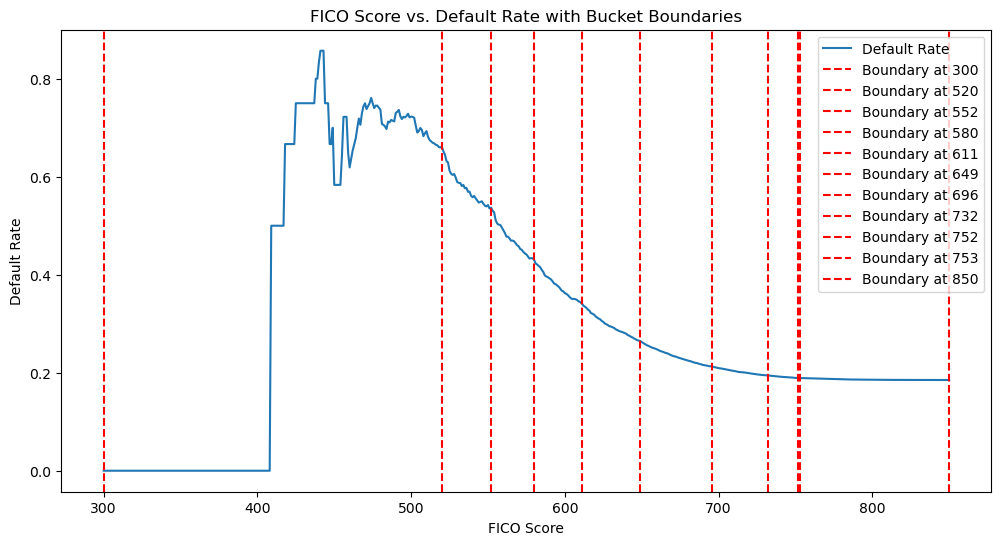

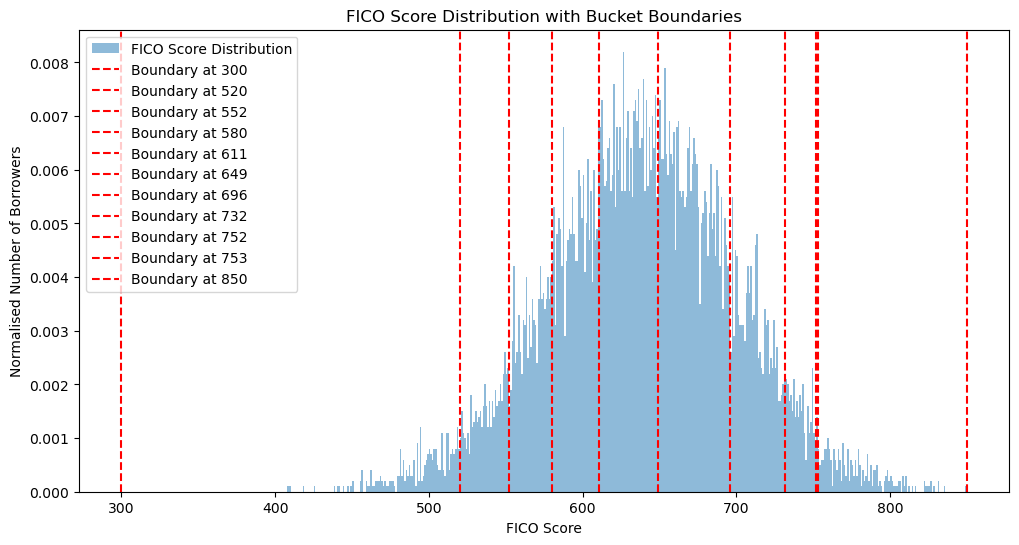

In [9]:
# Example usage:
quantizer = Quantizer('Task 3 and 4_Loan_Data.csv', 10)  # 10 partitions (buckets)
quantizer.prepare_data()
quantizer.compute_dp()
best_value, buckets = quantizer.get_optimal_partition()
quantizer.plot_results(buckets)